# test plot.ly d3 plots

- install 
    ````
    pip install plotly
    jupyter labextension install jupyterlab-plotly plotlywidget --no-build
    ````


- TODO
  - [X] make the smoothed plot below 
  - [X] holy crap this works
  - [ ] refactor the doubling time code into objects that make sense
  - [ ] fix up the plot.ly figure to look nice
  - [ ] figure out how to embed this in a github webpage


- histed 200408

In [20]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser

sns.set_style('whitegrid')

from src import covid_cases as cvd

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## load saved data

In [11]:
ctDf = pd.read_hdf('./ct-data/covidtracking-data-200408.h5', key='ct')

## first try at simple plot.ly

In [17]:
import plotly.express as px
import plotly.offline

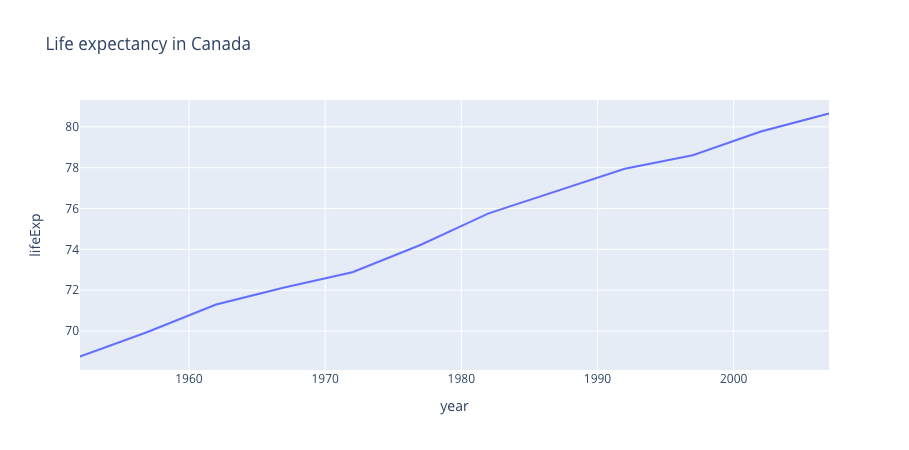

In [15]:
df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
# uncomment this to write an html file
#fig.write_html("./test.html", include_plotlyjs='cdn')
fig.show()

## constants

In [24]:
paramsC = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
paramsC.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
paramsC.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
paramsC.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
paramsC.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})
paramsC.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NY': -1})
paramsC.loc[:,'color'] = pd.Series({ 'NY': 0.4, 'DC': '#1f77b4', 'MD': '#ff7f0e', 'VA': '#2ca02c'})

#display(paramsC)

tDStr = datetime.date.today().strftime('%b %-d 2020')
tCredStr = 'Updated %s, 20:00 EDT\n  data: http://covidtracking.com\nGraphic: Hannah Goldbach, Mark Histed\n  @hannah_goldbach @histedlab' % tDStr
#print(tCredStr)

## refactor the prep code for the doubling-time plot

In [27]:
def double_time(st, doubles):
    dD = paramsC.loc[st, 'plot_data']
    slope0 = np.diff(np.log10(dD['ys'].to_numpy()))
    double_time = -np.log10(2)/slope0
    doubles[st] = double_time
    return(doubles)

def pct_rise(st, outDf):
    dD = paramsC.loc[st, 'plot_data']
    pctsTemp = []
    for tSt in np.arange(0, len(dD['xs'])-2, 1):
        ns = r_[0:2]+tSt
        x0 = np.mean(dD['xs'][ns])
        y0 = np.mean(dD['ys'].iloc[ns])
        slope0 = np.log10(dD['ys'].iloc[ns[0]])-np.log10(dD['ys'].iloc[ns[1]])
        pct_rise = (dD['ys'].iloc[ns[0]]/dD['ys'].iloc[ns[1]] * 100) - 100
        pctsTemp.append(pct_rise)
    pcts[st] = pctsTemp
    return pcts

def find_days(df): 
    df = df.reindex(index=df.index[::-1])
    df = df.reset_index(drop = True)
    df = df.reset_index()
    df = df.rename(columns = {'index': 'day'})
    return df

# run the plot_state data collector
df = ctDf.copy()
for st in ['DC', 'MD', 'VA', 'NY']:
    df, paramsC = cvd.plot_state(df, st, paramsC, ax=None, do_plot=False)


# manip
doubles = pd.DataFrame(columns = {'DC', 'VA', 'MD'})
pcts = pd.DataFrame(columns = {'DC', 'VA', 'MD'})

for st in ['DC', 'MD', 'VA']:
    doubles = double_time(st, doubles)
    pcts = pct_rise(st, pcts)

doubles = find_days(doubles)
pcts = find_days(pcts)

dtV = paramsC.loc['DC', 'plot_data']['dtV']

# pad with NAs
doubles = doubles.replace([np.inf, -np.inf], np.nan)
for st in ['DC', 'MD', 'VA']:
    doubles[st].fillna((doubles[st].mean()), inplace=True)

# smooth
for st in ['DC', 'MD', 'VA']:
    doubles[st+'_smooth'] = ptMH.math.smooth_lowess(doubles[st], x=None, span=7, robust=False, iter=None, axis=-1)

Latest data for DC: 2020-04-08 00:00:00
Latest data for MD: 2020-04-08 00:00:00
Latest data for VA: 2020-04-08 00:00:00
Latest data for NY: 2020-04-08 00:00:00


## make doubling time plot, export to plot.ly html 

wow this works?

In [32]:


for st in ['DC', 'MD', 'VA']:
    doubles[st+'_smooth'] = ptMH.math.smooth_lowess(doubles[st], x=None, span=8, robust=False, iter=None, axis=-1)

sns.set_style('whitegrid')
fig = plt.figure(figsize=r_[4, 3]*1.5, dpi=100)
fig.set_facecolor('#f6fcfd')
ax = plt.subplot()

for (iS,st) in enumerate(['DC', 'MD', 'VA']):
    pH, = plt.plot(doubles['day'], doubles[st], alpha = 0.8, lw = 0.75)
    plt.plot(doubles['day'], doubles[st+'_smooth'], label = st, lw = 2.5, color = pH.get_color())
    last_double = doubles[st+'_smooth'].iloc[-1]
    paramsC.loc[st, 'last_double'] = last_double
    paramsC.loc[st, 'color'] = pH.get_color()

# last_double annotate    
for (iS,st) in enumerate(['MD', 'DC', 'VA']):
    last_double = paramsC.loc[st, 'last_double']
    xy = (1.05, 0.65-iS*0.08)
    tStr = f'{st}: {last_double:.2g}'
    if iS == 0:
        tStr = tStr + ' days'
    ax.annotate(tStr, xy=xy, 
                xycoords='axes fraction', color=paramsC.loc[st, 'color'], ha='left',
                fontweight='bold', fontsize=14)
    
#plt.legend()
plt.ylabel('doubling time for cases (days)', fontsize=12)

plt.grid(False, which='both', axis='x')
sns.despine(left=True, right=True, top=False, bottom=False)

x_dates = dtV.dt.strftime('%b %-d')
xt = r_[5:len(x_dates):7]
ax.set_xticks(xt-1)
ax.set_ylim([0,ax.get_ylim()[-1]])
ax.tick_params(axis='x', length=5, bottom=True, direction='out', width=0.25)
ax.set_xticklabels(x_dates[::-1].iloc[xt], rotation=60)



ax.annotate(tCredStr, fontsize=8, va='bottom', ha='right',
              xy=(0.98,0.01), xycoords='axes fraction')
fig.suptitle('Tue Apr 7: Growth is slowing in Washington, DC area',
             fontsize=16, fontname='Roboto', fontweight='light',
             x=0.05, y=1.05, ha='left', va='top')



plotly.offline.plot_mpl(fig, filename='./fig-output/test-plotly.html', include_plotlyjs='cdn', auto_open=False)

#if doSave:
#    fig.savefig('./fig-output/doubling-MH-%s.png'%datestr, facecolor=fig.get_facecolor(),
#            dpi=300, bbox_inches='tight', pad_inches=0.5)

'./fig-output/test-plotly.html'